## 개인 프로젝트 : 악성 댓글 탐지
### 전처리 부분

### 0. 필요한 모듈 불러오기

In [2]:
import pandas as pd

import torch

from sklearn.model_selection import train_test_split

from konlpy.tag import Okt

from wordcloud.wordcloud import FONT_PATH
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from transformers import T5ForConditionalGeneration, T5Tokenizer

from tqdm import tqdm
tqdm.pandas()

### 1. 데이터 확인 및 전처리

- 데이터 특징
    - content, label 두 column으로 구성
    - 악성 댓글이면 0, 아니면 1
- 출처: https://github.com/ZIZUN/korean-malicious-comments-dataset

#### 1) 데이터 확인

In [3]:
# 데이터 불러오기

data = pd.read_csv('../datasets/Dataset.csv', sep='\t')

In [4]:
# 결측치 확인

data.isnull().sum()

content     0
lable      25
dtype: int64

In [6]:
# 결측치 있는 행 제거, 인덱스 초기화

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [7]:
# label 컬럼명 변경(lable -> label), 자료형 수정(실수 -> 정수)

data.rename(columns={'lable': 'label'}, inplace=True)
data['label'] = data['label'].apply(int)

In [8]:
# 악성 댓글을 1, 아닌 댓글을 0으로 변경

data['label'] = data['label'].apply(lambda x: 1-x)

In [9]:
# 클래스 불균형 정도 확인

data['label'].value_counts(normalize=True)

label
0    0.500451
1    0.499549
Name: proportion, dtype: float64

#### 2) 데이터 분리 & 축소
- 학습 시간 단축을 위해 원래 데이터에서 40%만 사용

In [10]:
X = data['content']
y = data['label']

X_use, _, y_use, _ = train_test_split(X, y, train_size=0.4, stratify=y, random_state=0)

In [11]:
use_data = pd.concat([X_use, y_use], axis=1)

#### 3) 맞춤법 수정

- https://github.com/jongmin-oh/korean-typos-corrector

In [12]:
# 맞춤법 수정 함수 작성

corr_model = T5ForConditionalGeneration.from_pretrained('j5ng/et5-typos-corrector')
tokenizer = T5Tokenizer.from_pretrained('j5ng/et5-typos-corrector')

device = "cuda" if torch.cuda.is_available() else "cpu"

corr_model = corr_model.to(device)

def corrector(sentence, corr_model, tokenizer, device):
    input_encoding = tokenizer("맞춤법을 고쳐주세요: " + sentence, return_tensors="pt")

    input_ids = input_encoding.input_ids.to(device)
    attention_mask = input_encoding.attention_mask.to(device)

    output_encoding = corr_model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        num_beams=5,
        early_stopping=True,
    )

    output_text = tokenizer.decode(output_encoding[0], skip_special_tokens=True)

    return output_text


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
# 맞춤법 수정

use_data['content'] = use_data['content'].progress_apply(corrector, args=(corr_model, tokenizer, device))

  1%|          | 21/3990 [00:45<2:24:04,  2.18s/it]


KeyboardInterrupt: 

In [31]:
use_data.to_csv('../datasets/Dataset.csv', index=False)

### 0~1. 데이터 재호출, 확인, 전처리

#### 1) 데이터 분리, 토큰화

In [17]:
data = pd.read_csv('../datasets/correction_data.csv')

In [18]:
# 토큰화 함수 작성

def tokenize(sentence):
    okt = Okt()
    pos_token = okt.pos(sentence, stem=True, norm=True)

    exclude_tag_list = ['Josa', 'PreEomi', 'Eomi', 'Punctuation', 'Foreign']
    # 조사, (선어말, 일반)어미, 구두점, 외국어/한자/기타 기호 제거

    after_pos = []

    for token, tag in pos_token:
        if tag not in exclude_tag_list:
            after_pos.append(token)

    return after_pos

In [20]:
X = data['content']
y = data['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=0)

In [22]:
# 토큰화 적용

X_train = X_train.progress_apply(tokenize)
X_val = X_val.progress_apply(tokenize)
X_test = X_test.progress_apply(tokenize)

100%|██████████| 399/399 [00:02<00:00, 179.96it/s]


In [24]:
# 악성 댓글과 악성이 아닌 댓글 따로 합치기

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train_0 = train[train['label'] == 0]
train_1 = train[train['label'] == 1]

#### 2) 시각화

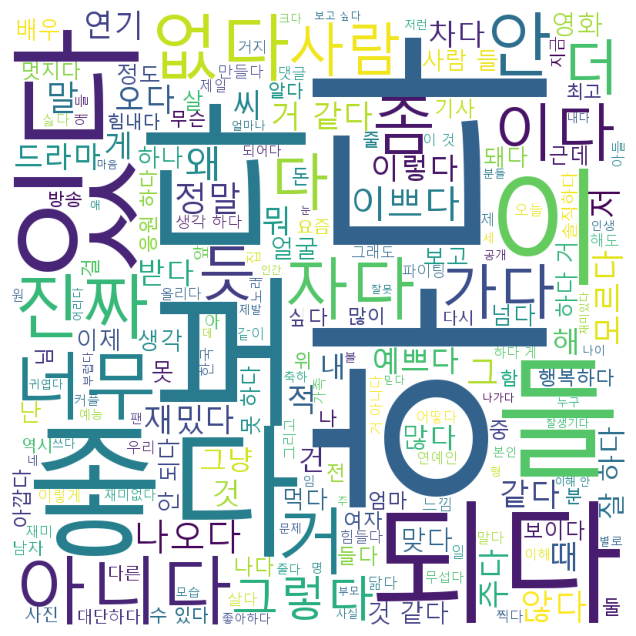

In [40]:
# 악성 아닌 댓글 시각화

text_0 = ' '.join(sum(train_0['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_0 = WordCloud(width=800, height=800,
                        font_path=FONT_PATH,
                        background_color='white',
                        min_font_size=10).generate(text_0)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_0)
plt.axis('off')

plt.show()

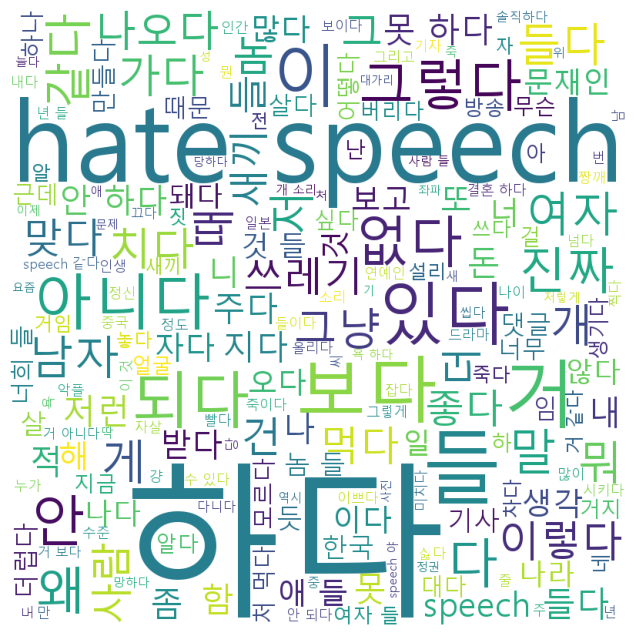

In [41]:
# 악성 댓글 시각화

text_1 = ' '.join(sum(train_1['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_1 = WordCloud(width=800, height=800,
                        font_path=FONT_PATH,
                        background_color='white',
                        min_font_size=10).generate(text_1)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_1)
plt.axis('off')

plt.show()

#### 3) 토큰화 함수 재작성

In [42]:
# '하다'는 자주 나오면서도 대체로 악성 여부를 판별하는 맥락과 무관하므로 불용어 처리

stopwords = ['하다']

In [48]:
# 토큰화 함수 재작성

def tokenize_new(sentence):
    okt = Okt()
    pos_token = okt.pos(sentence, stem=True, norm=True)
    # 정규화, 어간 추출 수행

    exclude_tag_list = ['Josa', 'PreEomi', 'Eomi', 'Punctuation', 'Foreign']
    # 조사, (선어말, 일반)어미, 구두점, 외국어/한자/기타 기호 제거

    after_pos = []

    for token, tag in pos_token:
        if tag not in exclude_tag_list:
            after_pos.append(token)

    tokens = [word for word in after_pos if word not in stopwords]

    return ' '.join(tokens)

In [49]:
# 다시 토큰화 진행

X = data['content']
y = data['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=0)

In [50]:
X_train = X_train.progress_apply(tokenize_new)
X_val = X_val.progress_apply(tokenize_new)
X_test = X_test.progress_apply(tokenize_new)

100%|██████████| 399/399 [00:02<00:00, 165.18it/s]


In [52]:
# 악성 댓글과 악성이 아닌 댓글 따로 합치기

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train_0 = train[train['label'] == 0]
train_1 = train[train['label'] == 1]

#### 4) 재시각화

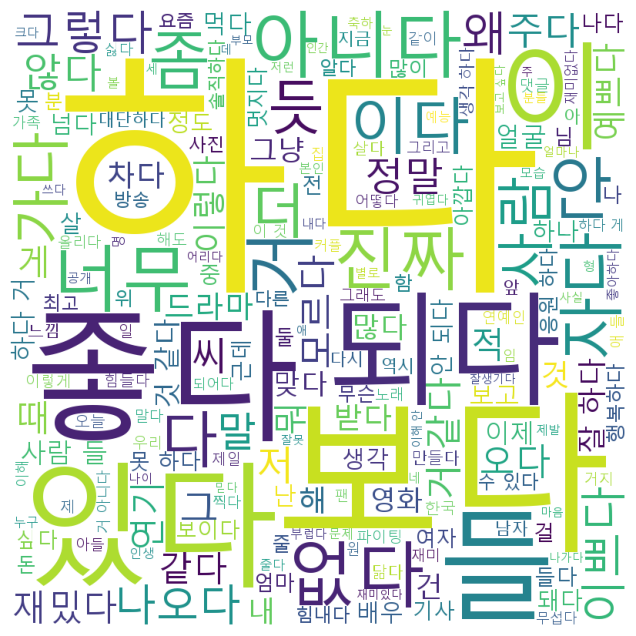

In [43]:
# 악성 댓글 시각화

text_0 = ' '.join(sum(train_0['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_0_new = WordCloud(width=800, height=800,
                            font_path=FONT_PATH,
                            background_color='white',
                            min_font_size=10).generate(text_0)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_0_new)
plt.axis('off')

plt.show()

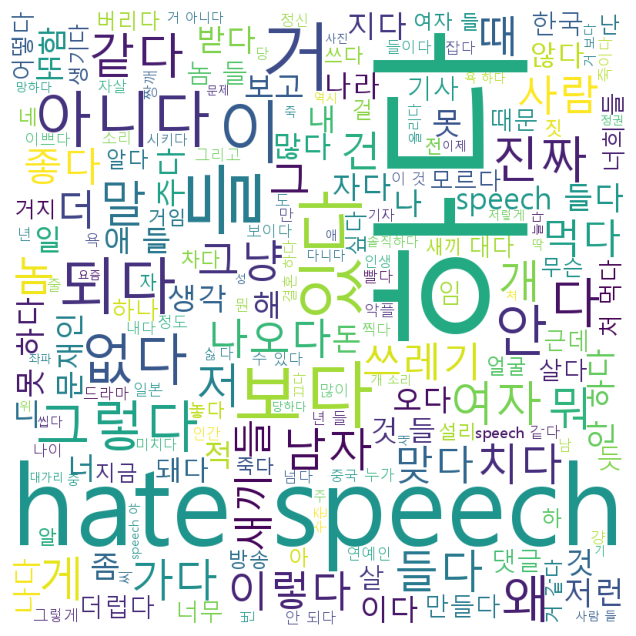

In [44]:
# 악성이 아닌 댓글 시각화

text_1 = ' '.join(sum(train_1['content'], []))

FONT_PATH = 'C:\Windows\Fonts\malgun.ttf'

wordcloud_1_new = WordCloud(width=800, height=800,
                            font_path=FONT_PATH,
                            background_color='white',
                            min_font_size=10).generate(text_1)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_1_new)
plt.axis('off')

plt.show()

### 2. 데이터 저장

In [45]:
train.to_csv('../datasets/train.csv', index=False)
val.to_csv('../datasets/val.csv', index=False)
test.to_csv('../datasets/test.csv', index=False)